# Choice Model Calibration Analysis

This notebook analyzes how the intercept parameter in the choice model affects trip acceptance rates for the NYC Manhattan scenario at hour 19.

## 1. Import Libraries

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import networkx as nx
import sys
sys.path.append('/work3/s233791/rl-pricing-amod')
from src.envs.amod_env_multi import Scenario

# Set plot style for professional appearance
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

## 2. Define Choice Model Parameters

These are the fixed parameters from the codebase (`src/envs/amod_env_multi.py`).

In [2]:
# Fixed choice model parameters from the code
TRAVEL_TIME_COEF = 0.71  # Coefficient for travel time
WAGE = 25.26  # Hourly wage in dollars
INCOME_EFFECT = WAGE / WAGE  # Income effect multiplier
CHOICE_PRICE_MULT = 1.0  # Default price multiplier
U_REJECT = 0  # Utility of rejecting the trip (outside option)

print("Choice Model Parameters:")
print(f"  Travel time coefficient: {TRAVEL_TIME_COEF}")
print(f"  Wage: ${WAGE}/hour")
print(f"  Income effect: {INCOME_EFFECT}")
print(f"  Price multiplier: {CHOICE_PRICE_MULT}")
print(f"  Rejection utility: {U_REJECT}")

Choice Model Parameters:
  Travel time coefficient: 0.71
  Wage: $25.26/hour
  Income effect: 1.0
  Price multiplier: 1.0
  Rejection utility: 0


## 3. Generate Demand for Simulation

In [17]:
# Create a Scenario object with the JSON file
scenario = Scenario(
    json_file="data/scenario_washington_dc.json",
    json_hr=19,  # Hour 19
    json_tstep=3,  # 3-minute time steps
    tf=20,
    impute = 0,
    demand_ratio=8.4,
    supply_ratio=1.0,
    fix_price=True
)

# Now call get_random_demand on the scenario object
trial_data = scenario.get_random_demand(reset=False)

In [ ]:
trial_data

[(0, 1, 0, 0, 0),
 (0, 2, 0, 0, 0),
 (0, 3, 0, 0, 0),
 (0, 4, 0, 0, 0),
 (0, 5, 0, 0, 0),
 (0, 6, 0, 0, 0),
 (0, 7, 0, 0, 0),
 (0, 8, 0, 0, 0),
 (0, 9, 0, 0, 0),
 (0, 0, 0, 0, 0),
 (1, 0, 0, 0, 0),
 (1, 2, 0, 0, 0),
 (1, 3, 0, 0, 0),
 (1, 4, 0, 0, 0),
 (1, 5, 0, 0, 0),
 (1, 6, 0, 0, 0),
 (1, 7, 0, 0, 0),
 (1, 8, 0, 0, 0),
 (1, 9, 0, 0, 0),
 (1, 1, 0, 0, 0),
 (2, 0, 0, 0, 0),
 (2, 1, 0, 1, 16.0),
 (2, 3, 0, 0, 0),
 (2, 4, 0, 0, 0),
 (2, 5, 0, 1, 38.4),
 (2, 6, 0, 0, 0),
 (2, 7, 0, 0, 0),
 (2, 8, 0, 0, 0),
 (2, 9, 0, 0, 0),
 (2, 2, 0, 0, 0),
 (3, 0, 0, 0, 0),
 (3, 1, 0, 0, 0),
 (3, 2, 0, 0, 0),
 (3, 4, 0, 0, 0),
 (3, 5, 0, 1, 13.599999999999998),
 (3, 6, 0, 0, 0),
 (3, 7, 0, 0, 0),
 (3, 8, 0, 2, 44.199999999999996),
 (3, 9, 0, 0, 0),
 (3, 3, 0, 0, 0),
 (4, 0, 0, 0, 0),
 (4, 1, 0, 0, 0),
 (4, 2, 0, 0, 0),
 (4, 3, 0, 0, 0),
 (4, 5, 0, 0, 0),
 (4, 6, 0, 0, 0),
 (4, 7, 0, 2, 19.9),
 (4, 8, 0, 1, 28.899999999999995),
 (4, 9, 0, 0, 0),
 (4, 4, 0, 0, 0),
 (5, 0, 0, 0, 0),
 (5, 1, 0, 0, 0),
 (5,

## 5. Analyze Trip Acceptance Across Intercept Values

## 6. Create Professional Visualization

In [18]:
# Define range of intercept values to test
intercept_range = np.linspace(8, 15, 100)

print("Two-agent Monte Carlo choice model simulation WITH POISSON SAMPLING")
print(f"Testing {len(intercept_range)} intercept values from {intercept_range[0]} to {intercept_range[-1]}")

# Run simulations
n_simulations = 50
proportion_accepted = []
accepted_demand_values = []
total_demand_values = []

for intercept in tqdm(intercept_range, desc="Testing intercept values"):
    accepted_counts = []
    total_counts = []
    
    # Run multiple Monte Carlo simulations
    for sim in range(n_simulations):
        total_accepted = 0
        total_demand = 0
        
        # Get a new random demand sample (Poisson sampling happens inside)
        trip_data = scenario.get_random_demand(reset=False)
        
        # trip_data is a list of tuples: (origin, destination, time_idx, demand, price)
        for origin, destination, time_idx, demand, price in trip_data:
            # demand is already an integer sampled from Poisson
            total_demand += demand
            
            # Get travel time for this O-D pair
            travel_time = scenario.demandTime[origin, destination][time_idx]
            travel_time_hours = travel_time / 60
            
            # Calculate utilities for both agents (same price for both in baseline)
            U_agent = intercept - TRAVEL_TIME_COEF * WAGE * travel_time_hours - INCOME_EFFECT * CHOICE_PRICE_MULT * price
            
            # Multinomial logit probabilities: agent0, agent1, reject
            exp_u_agent = np.exp(U_agent)
            exp_u_reject = np.exp(U_REJECT)
            sum_exp = 2 * exp_u_agent + exp_u_reject  # Both agents have same utility
            
            prob_accept = 2 * exp_u_agent / sum_exp  # Probability of acceptance by either agent
            
            # Sample each passenger
            for _ in range(int(demand)):
                if np.random.random() < prob_accept:
                    total_accepted += 1
        
        accepted_counts.append(total_accepted)
        total_counts.append(total_demand)
    
    # Store results
    mean_accepted = np.mean(accepted_counts)
    mean_total = np.mean(total_counts)
    proportion_accepted.append(mean_accepted / mean_total if mean_total > 0 else 0)
    accepted_demand_values.append(mean_accepted)
    total_demand_values.append(mean_total)

# Convert to arrays
intercept_range = np.array(intercept_range)
proportion_accepted = np.array(proportion_accepted)

# Find key values
idx_50 = np.argmin(np.abs(proportion_accepted - 0.5))

print(f"\nResults (averaged over {n_simulations} Poisson samples):")
print(f"  Mean total demand per simulation: {np.mean(total_demand_values):.1f} trips")
print(f"  At intercept={intercept_range[0]:.2f}: {proportion_accepted[0]:.2%}")
print(f"  At intercept={intercept_range[idx_50]:.2f} (50% acceptance): {proportion_accepted[idx_50]:.2%}")
print(f"  At intercept={intercept_range[-1]:.2f}: {proportion_accepted[-1]:.2%}")

Two-agent Monte Carlo choice model simulation WITH POISSON SAMPLING
Testing 100 intercept values from 8.0 to 15.0


Testing intercept values: 100%|██████████| 100/100 [07:39<00:00,  4.59s/it]


Results (averaged over 50 Poisson samples):
  Mean total demand per simulation: 16892.2 trips
  At intercept=8.00: 12.34%
  At intercept=11.75 (50% acceptance): 50.15%
  At intercept=15.00: 77.38%


## 7. Summary Statistics

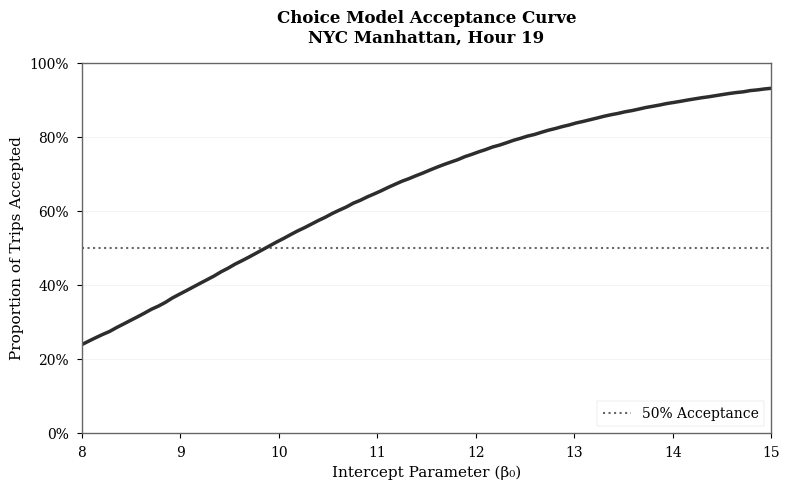


Figure saved to:
hoice_model_acceptance_curve.png
choice_model_acceptance_curve.pdf


In [7]:
# Create figure
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the main S-curve in gray tones
ax.plot(intercept_range, proportion_accepted, 
        color='#2d2d2d', linewidth=2.5)

# Add horizontal line at 50% acceptance
ax.axhline(y=0.5, color='#666666', linestyle=':', 
           linewidth=1.5, label='50% Acceptance', zorder=1)

# Add horizontal gridlines
ax.grid(True, axis='y', alpha=0.3, linestyle='-', linewidth=0.5, color='#cccccc')
ax.set_axisbelow(True)

# Labels and title
ax.set_xlabel('Intercept Parameter (β₀)', fontsize=11, fontweight='normal')
ax.set_ylabel('Proportion of Trips Accepted', fontsize=11, fontweight='normal')
ax.set_title('Choice Model Acceptance Curve\nNYC Manhattan, Hour 19', 
             fontsize=12, fontweight='bold', pad=15)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

# Set axis limits
ax.set_xlim(intercept_range[0], intercept_range[-1])
ax.set_ylim(0, 1.0)

# Add legend
ax.legend(loc='lower right', frameon=True, fancybox=False, 
          shadow=False, framealpha=0.95, edgecolor='#cccccc')

# Adjust spine colors
for spine in ax.spines.values():
    spine.set_edgecolor('#666666')
    spine.set_linewidth(1)

# Tight layout
plt.tight_layout()

# Save figure
plt.savefig('choice_model_acceptance_curve.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('choice_model_acceptance_curve.pdf', 
            bbox_inches='tight', facecolor='white')

plt.show()

print("\nFigure saved to:")
print("hoice_model_acceptance_curve.png")
print("choice_model_acceptance_curve.pdf")

## 9. Single-Agent Choice Model Analysis

Now we analyze the same scenario with a **single-agent** choice model to compare how rejection rates differ when there's only one agent competing.

In [19]:
intercept_range = np.linspace(8, 15, 100)

# Single-agent Monte Carlo choice model simulation WITH POISSON SAMPLING
print("Single-agent Monte Carlo choice model simulation WITH POISSON SAMPLING")
print(f"Testing {len(intercept_range)} intercept values from {intercept_range[0]} to {intercept_range[-1]}")

# Run simulations
n_simulations = 50
proportion_accepted_single = []
accepted_demand_values_single = []
total_demand_values_single = []

for intercept in tqdm(intercept_range, desc="Testing intercept values (single agent)"):
    accepted_counts = []
    total_counts = []
    
    # Run multiple Monte Carlo simulations
    for sim in range(n_simulations):
        total_accepted = 0
        total_demand = 0
        
        # Get a new random demand sample (Poisson sampling happens inside)
        trip_data = scenario.get_random_demand(reset=False)
        
        # trip_data is a list of tuples: (origin, destination, time_idx, demand, price)
        for origin, destination, time_idx, demand, price in trip_data:
            # demand is already an integer sampled from Poisson
            total_demand += demand
            
            # Get travel time for this O-D pair
            travel_time = scenario.demandTime[origin, destination][time_idx]
            travel_time_hours = travel_time / 60
            
            # Calculate utilities for single agent
            U_agent = intercept - TRAVEL_TIME_COEF * WAGE * travel_time_hours - INCOME_EFFECT * CHOICE_PRICE_MULT * price
            
            # Multinomial logit probabilities: agent, reject
            exp_u_agent = np.exp(U_agent)
            exp_u_reject = np.exp(U_REJECT)
            sum_exp = exp_u_agent + exp_u_reject  # Only one agent
            
            prob_accept = exp_u_agent / sum_exp  # Probability of acceptance by the single agent
            
            # Sample each passenger
            for _ in range(int(demand)):
                if np.random.random() < prob_accept:
                    total_accepted += 1
        
        accepted_counts.append(total_accepted)
        total_counts.append(total_demand)
    
    # Store results
    mean_accepted = np.mean(accepted_counts)
    mean_total = np.mean(total_counts)
    proportion_accepted_single.append(mean_accepted / mean_total if mean_total > 0 else 0)
    accepted_demand_values_single.append(mean_accepted)
    total_demand_values_single.append(mean_total)

# Convert to arrays
proportion_accepted_single = np.array(proportion_accepted_single)

# Find key values
idx_50_single = np.argmin(np.abs(proportion_accepted_single - 0.5))

print(f"\nResults (Single Agent, averaged over {n_simulations} Poisson samples):")
print(f"  Mean total demand per simulation: {np.mean(total_demand_values_single):.1f} trips")
print(f"  At intercept={intercept_range[0]:.2f}: {proportion_accepted_single[0]:.2%}")
print(f"  At intercept={intercept_range[idx_50_single]:.2f} (50% acceptance): {proportion_accepted_single[idx_50_single]:.2%}")
print(f"  At intercept={intercept_range[-1]:.2f}: {proportion_accepted_single[-1]:.2%}")

Single-agent Monte Carlo choice model simulation WITH POISSON SAMPLING
Testing 100 intercept values from 8.0 to 15.0


Testing intercept values (single agent): 100%|██████████| 100/100 [07:26<00:00,  4.46s/it]


Results (Single Agent, averaged over 50 Poisson samples):
  Mean total demand per simulation: 16894.7 trips
  At intercept=8.00: 8.06%
  At intercept=12.45 (50% acceptance): 50.30%
  At intercept=15.00: 72.65%


## 10. Compare Single-Agent vs Two-Agent Models

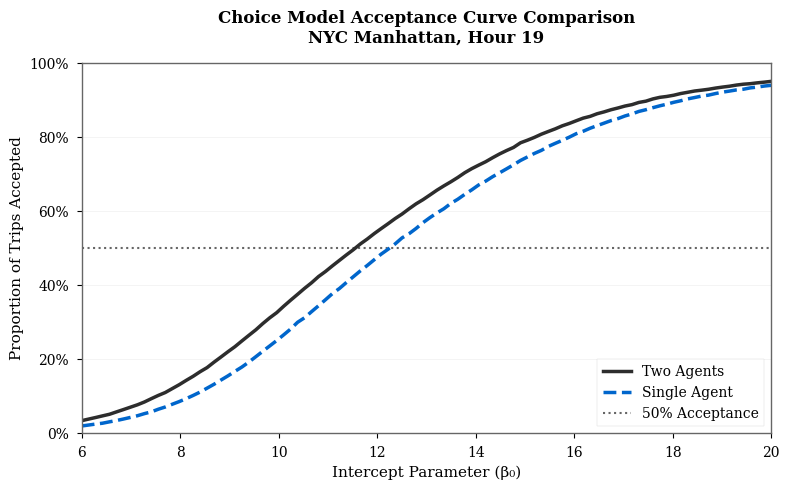


Figure saved to:
  - choice_model_comparison_1vs2_agents.png
  - choice_model_comparison_1vs2_agents.pdf


In [ ]:
# Create comparison figure
fig, ax = plt.subplots(figsize=(8, 5))

# Plot both curves
ax.plot(intercept_range, proportion_accepted, 
        color='#2d2d2d', linewidth=2.5, label='Two Agents')
ax.plot(intercept_range, proportion_accepted_single, 
        color='#0066cc', linewidth=2.5, linestyle='--', label='Single Agent')

# Add horizontal line at 50% acceptance
ax.axhline(y=0.5, color='#666666', linestyle=':', 
           linewidth=1.5, label='50% Acceptance', zorder=1)

# Add horizontal gridlines
ax.grid(True, axis='y', alpha=0.3, linestyle='-', linewidth=0.5, color='#cccccc')
ax.set_axisbelow(True)

# Labels and title
ax.set_xlabel('Intercept Parameter (β₀)', fontsize=11, fontweight='normal')
ax.set_ylabel('Proportion of Trips Accepted', fontsize=11, fontweight='normal')
ax.set_title('Choice Model Acceptance Curve Comparison\nNYC Manhattan, Hour 19', 
             fontsize=12, fontweight='bold', pad=15)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

# Set axis limits
ax.set_xlim(intercept_range[0], intercept_range[-1])
ax.set_ylim(0, 1.0)

# Add legend
ax.legend(loc='lower right', frameon=True, fancybox=False, 
          shadow=False, framealpha=0.95, edgecolor='#cccccc')

# Adjust spine colors
for spine in ax.spines.values():
    spine.set_edgecolor('#666666')
    spine.set_linewidth(1)

# Tight layout
plt.tight_layout()

# Save figure
plt.savefig('choice_model_comparison_1vs2_agents.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('choice_model_comparison_1vs2_agents.pdf', 
            bbox_inches='tight', facecolor='white')

plt.show()

print("\nFigure saved to:")
print("  - choice_model_comparison_1vs2_agents.png")
print("  - choice_model_comparison_1vs2_agents.pdf")

In [ ]:
# Create comparison summary dataframe
comparison_df = pd.DataFrame({
    'Intercept': intercept_range,
    'Two_Agent_Acceptance': proportion_accepted,
    'Single_Agent_Acceptance': proportion_accepted_single,
    'Difference': proportion_accepted - proportion_accepted_single
})

# Find key intercept values for single agent
idx_10_single = np.argmin(np.abs(proportion_accepted_single - 0.1))
idx_25_single = np.argmin(np.abs(proportion_accepted_single - 0.25))
idx_50_single = np.argmin(np.abs(proportion_accepted_single - 0.5))
idx_75_single = np.argmin(np.abs(proportion_accepted_single - 0.75))
idx_90_single = np.argmin(np.abs(proportion_accepted_single - 0.9))

print("=" * 80)
print("COMPARISON: SINGLE-AGENT vs TWO-AGENT MODELS")
print("=" * 80)
print(f"\nIntercept values for target acceptance rates:")
print(f"\n{'Target':<15} {'Two-Agent β₀':<15} {'Single-Agent β₀':<20} {'Difference':<10}")
print("-" * 80)
print(f"{'10% acceptance':<15} {intercept_range[idx_10]:<15.2f} {intercept_range[idx_10_single]:<20.2f} {intercept_range[idx_10_single]-intercept_range[idx_10]:<10.2f}")
print(f"{'25% acceptance':<15} {intercept_range[idx_25]:<15.2f} {intercept_range[idx_25_single]:<20.2f} {intercept_range[idx_25_single]-intercept_range[idx_25]:<10.2f}")
print(f"{'50% acceptance':<15} {intercept_range[idx_50]:<15.2f} {intercept_range[idx_50_single]:<20.2f} {intercept_range[idx_50_single]-intercept_range[idx_50]:<10.2f}")
print(f"{'75% acceptance':<15} {intercept_range[idx_75]:<15.2f} {intercept_range[idx_75_single]:<20.2f} {intercept_range[idx_75_single]-intercept_range[idx_75]:<10.2f}")
print(f"{'90% acceptance':<15} {intercept_range[idx_90]:<15.2f} {intercept_range[idx_90_single]:<20.2f} {intercept_range[idx_90_single]-intercept_range[idx_90]:<10.2f}")
print("=" * 80)
print("\nKey insight: Single-agent model requires HIGHER intercept to achieve same acceptance rate")
print("because there's only one agent available instead of two competing agents.")

# Display sample comparison
print("\nSample comparison (every 20th value):")
display(comparison_df.iloc[::20].round(3))

COMPARISON: SINGLE-AGENT vs TWO-AGENT MODELS

Intercept values for target acceptance rates:

Target          Two-Agent β₀    Single-Agent β₀      Difference
--------------------------------------------------------------------------------
10% acceptance  6.85            8.26                 1.41      
25% acceptance  8.40            9.96                 1.56      
50% acceptance  11.52           12.22                0.71      
75% acceptance  12.36           15.05                2.69      
90% acceptance  14.63           18.16                3.54      

Key insight: Single-agent model requires HIGHER intercept to achieve same acceptance rate
because there's only one agent available instead of two competing agents.

Sample comparison (every 20th value):


,Intercept,Two_Agent_Acceptance,Single_Agent_Acceptance,Difference
0,6.000,0.034,0.020,0.014
20,8.828,0.207,0.144,0.062
40,11.657,0.512,0.439,0.073
60,14.485,0.755,0.704,0.051
80,17.313,0.895,0.870,0.024


## 11. Price Sensitivity Analysis Across Cities

Analyze how price scalars affect rejection rates across three cities: NYC Manhattan South, Washington DC, and San Francisco.

In [3]:
# Fixed choice model parameters from the code
TRAVEL_TIME_COEF = 0.71  # Coefficient for travel time
INCOME_EFFECT = 1
CHOICE_PRICE_MULT = 1.0  # Default price multiplier
U_REJECT = 0  # Utility of rejecting the trip (outside option)


# Define city-specific parameters
cities = ['nyc_man_south', 'washington_dc', 'san_francisco']
city_names = {
    'nyc_man_south': 'NYC Manhattan South',
    'washington_dc': 'Washington DC',
    'san_francisco': 'San Francisco'
}

# Parameters from main_a2c_multi_agent.py (dual agent)
demand_ratio = {'san_francisco': 2, 'nyc_man_south': 1.0, 'washington_dc': 4.2}
json_hr = {'san_francisco': 19, 'nyc_man_south': 19, 'washington_dc': 19}
choice_intercept_dual = {'san_francisco': 14.15, 'nyc_man_south': 9.84, 'washington_dc': 11.75}
wage = {'san_francisco': 17.76, 'nyc_man_south': 22.77, 'washington_dc': 25.26}
test_tstep = {'san_francisco': 3, 'nyc_man_south': 3, 'washington_dc': 3}

# Parameters from main_a2c.py (single agent)
choice_intercept_single = {'san_francisco': 14.79, 'nyc_man_south': 10.55, 'washington_dc': 12.45}

print("City-specific parameters loaded:")
for city in cities:
    print(f"\n{city_names[city]}:")
    print(f"  Demand ratio: {demand_ratio[city]}")
    print(f"  JSON hour: {json_hr[city]}")
    print(f"  Choice intercept (dual): {choice_intercept_dual[city]}")
    print(f"  Choice intercept (single): {choice_intercept_single[city]}")
    print(f"  Wage: ${wage[city]}/hour")
    print(f"  Timestep: {test_tstep[city]} minutes")

City-specific parameters loaded:

NYC Manhattan South:
  Demand ratio: 1.0
  JSON hour: 19
  Choice intercept (dual): 9.84
  Choice intercept (single): 10.55
  Wage: $22.77/hour
  Timestep: 3 minutes

Washington DC:
  Demand ratio: 4.2
  JSON hour: 19
  Choice intercept (dual): 11.75
  Choice intercept (single): 12.45
  Wage: $25.26/hour
  Timestep: 3 minutes

San Francisco:
  Demand ratio: 2
  JSON hour: 19
  Choice intercept (dual): 14.15
  Choice intercept (single): 14.79
  Wage: $17.76/hour
  Timestep: 3 minutes


In [4]:
# Define price scalar range (0 to 2 with 0.1 increments)
price_scalar_range = np.arange(0, 2.1, 0.1)
n_simulations = 50

print(f"Testing {len(price_scalar_range)} price scalars from {price_scalar_range[0]:.1f} to {price_scalar_range[-1]:.1f}")
print(f"Running {n_simulations} Monte Carlo simulations per price scalar")
print(f"Total simulations per city: {len(price_scalar_range) * n_simulations}")

Testing 21 price scalars from 0.0 to 2.0
Running 50 Monte Carlo simulations per price scalar
Total simulations per city: 1050


In [5]:
# Run price sensitivity analysis for all cities
results_by_city = {}

for city in cities:
    print(f"\n{'='*80}")
    print(f"Running analysis for {city_names[city]}")
    print(f"{'='*80}")
    
    # Create scenario for this city
    city_scenario = Scenario(
        json_file=f"data/scenario_{city}.json",
        json_hr=json_hr[city],
        json_tstep=test_tstep[city],
        tf=20,
        impute=0,
        demand_ratio=demand_ratio[city]*2,
        supply_ratio=1.0,
        fix_price=True
    )
    
    # Get city-specific parameters
    intercept = choice_intercept_dual[city]
    wage_value = wage[city]
    
    # Store rejection rates for each price scalar
    rejection_rates = []
    
    for price_scalar in tqdm(price_scalar_range, desc=f"Testing price scalars for {city}"):
        rejected_counts = []
        total_counts = []
        
        # Run multiple Monte Carlo simulations
        for sim in range(n_simulations):
            total_rejected = 0
            total_demand = 0
            
            # Get a new random demand sample
            trip_data = city_scenario.get_random_demand(reset=False)
            
            for origin, destination, time_idx, demand, base_price in trip_data:
                total_demand += demand
                
                # Apply price scalar to base price
                price = base_price * price_scalar
                
                # Get travel time for this O-D pair
                travel_time = city_scenario.demandTime[origin, destination][time_idx]
                travel_time_hours = travel_time / 60
                
                # Calculate utilities for both agents (same price for both)
                U_agent = intercept - TRAVEL_TIME_COEF * wage_value * travel_time_hours - INCOME_EFFECT * price
                
                # Multinomial logit probabilities: agent0, agent1, reject
                exp_u_agent = np.exp(U_agent)
                exp_u_reject = np.exp(U_REJECT)
                sum_exp = 2 * exp_u_agent + exp_u_reject
                
                prob_reject = exp_u_reject / sum_exp
                
                # Sample each passenger
                for _ in range(int(demand)):
                    if np.random.random() < prob_reject:
                        total_rejected += 1
            
            rejected_counts.append(total_rejected)
            total_counts.append(total_demand)
        
        # Calculate mean rejection rate
        mean_rejected = np.mean(rejected_counts)
        mean_total = np.mean(total_counts)
        rejection_rate = mean_rejected / mean_total if mean_total > 0 else 0
        rejection_rates.append(rejection_rate)
    
    # Store results for this city
    results_by_city[city] = {
        'price_scalars': price_scalar_range,
        'rejection_rates': np.array(rejection_rates),
        'mean_total_demand': np.mean(total_counts)
    }
    
    print(f"Completed {city_names[city]}")
    print(f"  Mean total demand per simulation: {results_by_city[city]['mean_total_demand']:.1f} trips")
    print(f"  Rejection rate at scalar 0.0: {rejection_rates[0]:.2%}")
    print(f"  Rejection rate at scalar 1.0: {rejection_rates[10]:.2%}")
    print(f"  Rejection rate at scalar 2.0: {rejection_rates[-1]:.2%}")

print(f"\n{'='*80}")
print("Analysis complete for all cities!")
print(f"{'='*80}")


Running analysis for NYC Manhattan South


Testing price scalars for nyc_man_south: 100%|██████████| 21/21 [00:48<00:00,  2.31s/it]


Completed NYC Manhattan South
  Mean total demand per simulation: 21181.8 trips
  Rejection rate at scalar 0.0: 0.01%
  Rejection rate at scalar 1.0: 50.22%
  Rejection rate at scalar 2.0: 99.65%

Running analysis for Washington DC


Testing price scalars for washington_dc: 100%|██████████| 21/21 [01:33<00:00,  4.43s/it]


Completed Washington DC
  Mean total demand per simulation: 16875.2 trips
  Rejection rate at scalar 0.0: 0.00%
  Rejection rate at scalar 1.0: 49.67%
  Rejection rate at scalar 2.0: 99.00%

Running analysis for San Francisco


Testing price scalars for san_francisco: 100%|██████████| 21/21 [00:27<00:00,  1.32s/it]

Completed San Francisco
  Mean total demand per simulation: 5452.2 trips
  Rejection rate at scalar 0.0: 0.00%
  Rejection rate at scalar 1.0: 49.52%
  Rejection rate at scalar 2.0: 99.99%

Analysis complete for all cities!


In [6]:
# Run price sensitivity analysis for all cities - SINGLE AGENT
results_by_city_single = {}

for city in cities:
    print(f"\n{'='*80}")
    print(f"Running SINGLE AGENT analysis for {city_names[city]}")
    print(f"{'='*80}")
    
    # Use the same scenario as dual agent
    city_scenario = Scenario(
        json_file=f"data/scenario_{city}.json",
        json_hr=json_hr[city],
        json_tstep=test_tstep[city],
        tf=20,
        impute=0,
        demand_ratio=demand_ratio[city]*2,
        supply_ratio=1.0,
        fix_price=True
    )
    
    # Get city-specific parameters for SINGLE agent
    intercept = choice_intercept_single[city]
    wage_value = wage[city]
    
    # Store rejection rates for each price scalar
    rejection_rates = []
    
    for price_scalar in tqdm(price_scalar_range, desc=f"Testing price scalars for {city} (single agent)"):
        rejected_counts = []
        total_counts = []
        
        # Run multiple Monte Carlo simulations
        for sim in range(n_simulations):
            total_rejected = 0
            total_demand = 0
            
            # Get a new random demand sample
            trip_data = city_scenario.get_random_demand(reset=False)
            
            for origin, destination, time_idx, demand, base_price in trip_data:
                total_demand += demand
                
                # Apply price scalar to base price
                price = base_price * price_scalar
                
                # Get travel time for this O-D pair
                travel_time = city_scenario.demandTime[origin, destination][time_idx]
                travel_time_hours = travel_time / 60
                
                # Calculate utilities for SINGLE agent
                U_agent = intercept - TRAVEL_TIME_COEF * wage_value * travel_time_hours - INCOME_EFFECT * price
                
                # Multinomial logit probabilities: agent, reject (SINGLE AGENT)
                exp_u_agent = np.exp(U_agent)
                exp_u_reject = np.exp(U_REJECT)
                sum_exp = exp_u_agent + exp_u_reject  # Only one agent
                
                prob_reject = exp_u_reject / sum_exp
                
                # Sample each passenger
                for _ in range(int(demand)):
                    if np.random.random() < prob_reject:
                        total_rejected += 1
            
            rejected_counts.append(total_rejected)
            total_counts.append(total_demand)
        
        # Calculate mean rejection rate
        mean_rejected = np.mean(rejected_counts)
        mean_total = np.mean(total_counts)
        rejection_rate = mean_rejected / mean_total if mean_total > 0 else 0
        rejection_rates.append(rejection_rate)
    
    # Store results for this city
    results_by_city_single[city] = {
        'price_scalars': price_scalar_range,
        'rejection_rates': np.array(rejection_rates),
        'mean_total_demand': np.mean(total_counts)
    }
    
    print(f"Completed {city_names[city]} (SINGLE AGENT)")
    print(f"  Mean total demand per simulation: {results_by_city_single[city]['mean_total_demand']:.1f} trips")
    print(f"  Rejection rate at scalar 0.0: {rejection_rates[0]:.2%}")
    print(f"  Rejection rate at scalar 1.0: {rejection_rates[10]:.2%}")
    print(f"  Rejection rate at scalar 2.0: {rejection_rates[-1]:.2%}")

print(f"\n{'='*80}")
print("SINGLE AGENT analysis complete for all cities!")
print(f"{'='*80}")


Running SINGLE AGENT analysis for NYC Manhattan South


Testing price scalars for nyc_man_south (single agent):   0%|          | 0/21 [00:00<?, ?it/s]

Testing price scalars for nyc_man_south (single agent): 100%|██████████| 21/21 [00:47<00:00,  2.26s/it]


Completed NYC Manhattan South (SINGLE AGENT)
  Mean total demand per simulation: 21225.4 trips
  Rejection rate at scalar 0.0: 0.01%
  Rejection rate at scalar 1.0: 50.07%
  Rejection rate at scalar 2.0: 99.64%

Running SINGLE AGENT analysis for Washington DC


Testing price scalars for washington_dc (single agent): 100%|██████████| 21/21 [01:31<00:00,  4.37s/it]


Completed Washington DC (SINGLE AGENT)
  Mean total demand per simulation: 16868.1 trips
  Rejection rate at scalar 0.0: 0.00%
  Rejection rate at scalar 1.0: 49.72%
  Rejection rate at scalar 2.0: 99.01%

Running SINGLE AGENT analysis for San Francisco


Testing price scalars for san_francisco (single agent): 100%|██████████| 21/21 [00:27<00:00,  1.32s/it]

Completed San Francisco (SINGLE AGENT)
  Mean total demand per simulation: 5471.7 trips
  Rejection rate at scalar 0.0: 0.00%
  Rejection rate at scalar 1.0: 50.26%
  Rejection rate at scalar 2.0: 99.99%

SINGLE AGENT analysis complete for all cities!


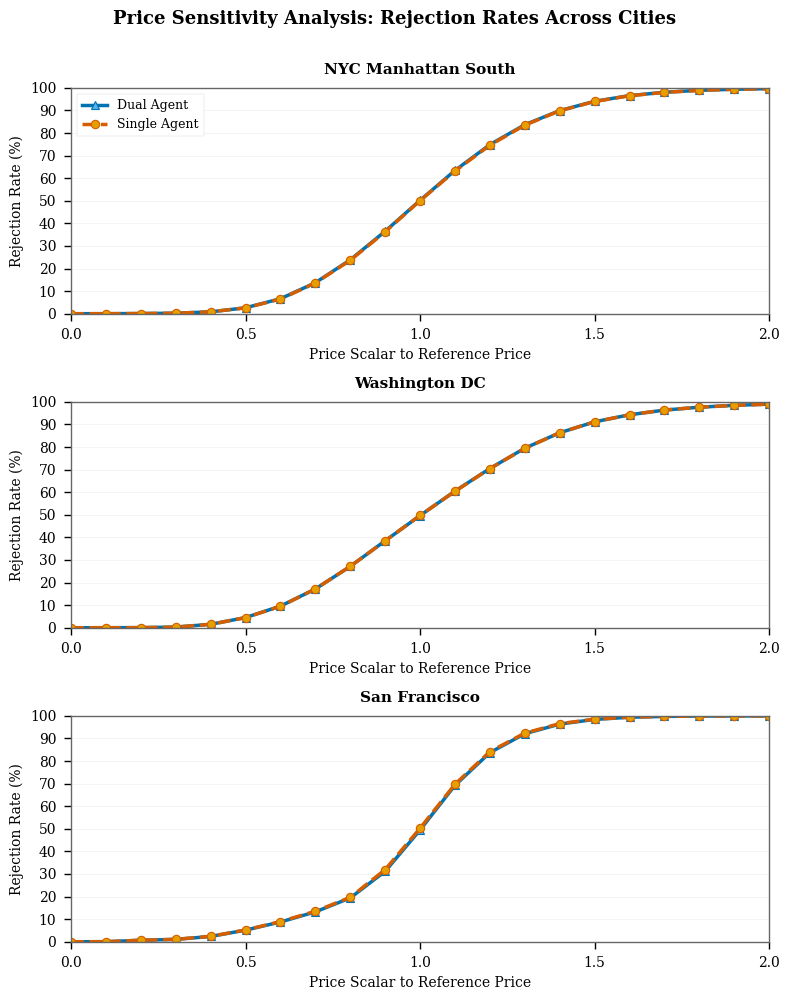


Figure saved to:
  - price_sensitivity_rejection_rates.png


In [7]:
# Create three-panel figure with rejection rates (dual and single agent)
fig, axes = plt.subplots(3, 1, figsize=(8, 10))

for idx, city in enumerate(cities):
    ax = axes[idx]
    
    # Plot dual agent rejection rate with triangle markers
    ax.plot(results_by_city[city]['price_scalars'], 
            results_by_city[city]['rejection_rates'] * 100,  # Convert to percentage
            color='#0072B2', linewidth=2.5, marker='^', markersize=6, markevery=1,
            markerfacecolor='#56B4E9', markeredgecolor='#0072B2', markeredgewidth=0.8,
            label='Dual Agent')
    
    # Plot single agent rejection rate with circle markers
    ax.plot(results_by_city_single[city]['price_scalars'], 
            results_by_city_single[city]['rejection_rates'] * 100,  # Convert to percentage
            color='#D55E00', linewidth=2.5, marker='o', markersize=6, markevery=1,
            markerfacecolor='#E69F00', markeredgecolor='#D55E00', markeredgewidth=0.8,
            label='Single Agent', linestyle='--')
    
    # Add horizontal gridlines
    ax.grid(True, axis='y', alpha=0.3, linestyle='-', linewidth=0.5, color='#cccccc')
    ax.set_axisbelow(True)
    
    # Set subtitle with city name
    ax.set_title(city_names[city], fontsize=11, fontweight='bold', pad=10)
    
    # Labels
    ax.set_xlabel('Price Scalar to Reference Price', fontsize=10, fontweight='normal')
    ax.set_ylabel('Rejection Rate (%)', fontsize=10, fontweight='normal')
    
    # Set axis limits
    ax.set_xlim(0, 2.0)
    ax.set_ylim(0, 100)
    
    # Set x-axis ticks at 0.5 intervals
    ax.set_xticks(np.arange(0, 2.1, 0.5))
    
    # Set y-axis ticks at 10% intervals
    ax.set_yticks(np.arange(0, 101, 10))
    
    # Add legend (only on the first subplot to avoid redundancy)
    if idx == 0:
        ax.legend(loc='upper left', frameon=True, fancybox=False, 
                  shadow=False, framealpha=0.95, edgecolor='#cccccc', fontsize=9)
    
    # Adjust spine colors
    for spine in ax.spines.values():
        spine.set_edgecolor('#666666')
        spine.set_linewidth(1)
    
    # Move ticks outside
    ax.tick_params(direction='out', length=5, width=1)

# Add overall title
fig.suptitle('Price Sensitivity Analysis: Rejection Rates Across Cities', 
             fontsize=13, fontweight='bold', y=0.995)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.99])

# Save figure
plt.savefig('price_sensitivity_rejection_rates.png', 
            dpi=300, bbox_inches='tight', facecolor='white')

plt.show()

print("\nFigure saved to:")
print("  - price_sensitivity_rejection_rates.png")